# Single Shot Detector (SSD) with the LISA Dataset

### Original notebook from: https://github.com/rohitgeo/singleshotdetector

After seeing videos of results and other successful implementations of SSD on the LISA dataset, we knew we had to give it a try. We found this notebook which was created as part of the fastai learning material. We were able to adapt their implementation to work with the LISA dataset and get some promising results.

## Utility functions

In [23]:
import torch
from torch import nn
import torch.nn.functional as F

def conv_params(in_size, out_size):
    filters = [3,2,5,4]
    strides = [1,2,3] # max_stride = 3
    pads = [0,1,2,3] # max pad
    
    if out_size == 1:
        return 1, 0, in_size
    
    for filter_size in filters:
        for pad in pads:
            for stride in strides:
                if ((out_size - 1) * stride == (in_size - filter_size) + 2 * pad):
                    return stride, pad, filter_size
    return None, None, None

class StdConv(nn.Module):
    def __init__(self, nin, nout, filter_size=3, stride=2, padding=1, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, filter_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): 
        return self.drop(self.bn(F.relu(self.conv(x))))
        
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, num_classes, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (num_classes)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
    
class SSDHead(nn.Module):
    def __init__(self, grids, anchors_per_cell, num_classes, drop=0.3, bias=-4.):
        super().__init__()
        self.drop = nn.Dropout(drop)
        
        self.sconvs = nn.ModuleList([])
        self.oconvs = nn.ModuleList([])
        
        self.anc_grids = grids
        
        self._k = anchors_per_cell

        
        self.sconvs.append(StdConv(512, 256, stride=1, drop=drop))
        
        
        for i in range(len(grids)):
            
            if i == 0:
                stride, pad, filter_size = conv_params(7, grids[i]) # get '7' by base model
            else:
                stride, pad, filter_size = conv_params(grids[i-1], grids[i])
            
            if stride is None:
                print(grids[i-1], ' --> ', grids[i])
                raise Exception('cannot create model for specified grids')
                
            self.sconvs.append(StdConv(256, 256, filter_size, stride=stride, padding=pad, drop=drop))
            self.oconvs.append(OutConv(self._k, 256, num_classes=num_classes, bias=bias))
                
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconvs[0](x)
        out_classes = []
        out_bboxes = []
        for sconv, oconv in zip(self.sconvs[1:], self.oconvs):
            x = sconv(x)
            out_class, out_bbox = oconv(x)
            out_classes.append(out_class)
            out_bboxes.append(out_bbox)
            
        return [torch.cat(out_classes, dim=1),
                torch.cat(out_bboxes, dim=1)]

def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes)
        t = torch.Tensor(t[:,1:].contiguous()).cuda()
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/(self.num_classes-1)
    
    def get_weight(self,x,t): return None

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        w = w * (1-pt).pow(gamma)
        return w.detach()

## The heart of SSD

In [33]:
import torch
from fastai.vision.learner import cnn_learner
from torchvision.models import resnet34
import numpy as np
import json
import os
from pathlib import Path

class _EmptyData():
    def __init__(self, path, c, loss_func: None):
        self.path = path
        self.device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
        self.c = c
        self.loss_func = loss_func

class SingleShotDetector(object):
    
    def __init__(self, data, grids=[4, 2, 1], zooms=[0.7, 1., 1.3], ratios=[[1., 1.], [1., 0.5], [0.5, 1.]], 
                 backbone=None, drop=0.3, bias=-4., focal_loss=False, pretrained_path=None):
        
        super().__init__()

        self._device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')


        if backbone is None:
            backbone = resnet34
            
        self._create_anchors(grids, zooms, ratios)
        
        ssd_head = SSDHead(grids, self._anchors_per_cell, data.c, drop=drop, bias=bias)

        self._data = data
        self.learn = cnn_learner(data=data, base_arch=backbone, custom_head=ssd_head)
        self.learn.model = self.learn.model.to(self._device)

        if pretrained_path is not None:
            self.load(pretrained_path)
        
        if focal_loss:
            self._loss_f = FocalLoss(data.c)
        else:
            self._loss_f = BCE_Loss(data.c)
            
        self.learn.loss_func = self._ssd_loss

    @classmethod
    def from_emd(cls, data, emd_path):
        emd = json.load(open(emd_path))
        class_mapping = {i['Value'] : i['Name'] for i in emd['Classes']}
        if data is None:
            empty_data = _EmptyData(path='str', loss_func=None, c=len(class_mapping) + 1)
            return cls(empty_data, emd['Grids'], emd['Zooms'], emd['Ratios'], pretrained_path=emd['ModelFile'])
        else:
            return cls(data, emd['Grids'], emd['Zooms'], emd['Ratios'], pretrained_path=emd['ModelFile'])

    
    def lr_find(self):
        from IPython.display import clear_output
        self.learn.lr_find()
        clear_output()
        self.learn.recorder.plot()
        
    def fit(self, epochs=10, lr=slice(1e-4,3e-3)):
        self.learn.fit(epochs, lr)

    def unfreeze():
        self.learn.unfreeze()
        
    def _create_anchors(self, anc_grids, anc_zooms, anc_ratios):
        
        self.grids = anc_grids
        self.zooms = anc_zooms
        self.ratios =  anc_ratios

        anchor_scales = [(anz*i, anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
        
        self._anchors_per_cell = len(anchor_scales)
        
        anc_offsets = [1/(o*2) for o in anc_grids]

        anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                                for ao,ag in zip(anc_offsets,anc_grids)])
        anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                                for ao,ag in zip(anc_offsets,anc_grids)])
        anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), self._anchors_per_cell, axis=0)

        anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
                       for ag in anc_grids])
        
        self._grid_sizes = torch.Tensor(np.concatenate([np.array([ 1/ag  for i in range(ag*ag) for o,p in anchor_scales])
                       for ag in anc_grids])).unsqueeze(1).to(self._device)
        
        self._anchors = torch.Tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float().to(self._device)
        
        self._anchor_cnr = self._hw2corners(self._anchors[:,:2], self._anchors[:,2:])
        
    def _hw2corners(self, ctr, hw): 
        return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

    def _get_y(self, bbox, clas):
        bbox = bbox.view(-1,4) #/sz
        bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
        return bbox[bb_keep],clas[bb_keep]

    def _actn_to_bb(self, actn, anchors, grid_sizes):
        actn_bbs = torch.tanh(actn)
        actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
        actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
        return self._hw2corners(actn_centers, actn_hw)

    def _map_to_ground_truth(self, overlaps, print_it=False):
        prior_overlap, prior_idx = overlaps.max(1)
        if print_it: print(prior_overlap)
        gt_overlap, gt_idx = overlaps.max(0)
        gt_overlap[prior_idx] = 1.99
        for i,o in enumerate(prior_idx): gt_idx[o] = i
        return gt_overlap, gt_idx
        
        
    def _ssd_1_loss(self, b_c, b_bb, bbox, clas, print_it=False):
        bbox,clas = self._get_y(bbox,clas)
        bbox = self._normalize_bbox(bbox)

        a_ic = self._actn_to_bb(b_bb, self._anchors, self._grid_sizes)
        overlaps = self._jaccard(bbox.data, self._anchor_cnr.data)
        try:
            gt_overlap,gt_idx = self._map_to_ground_truth(overlaps,print_it)
        except Exception as e:
            return 0.,0.
        gt_clas = clas[gt_idx]
        pos = gt_overlap > 0.4
        pos_idx = torch.nonzero(pos)[:,0]
        gt_clas[~pos] = 0 #data.c - 1 # CHANGE
        gt_bbox = bbox[gt_idx]
        loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
        clas_loss  = self._loss_f(b_c, gt_clas)
        return loc_loss, clas_loss
    
    def _ssd_loss(self, pred, targ1, targ2, print_it=False):
        lcs,lls = 0.,0.
        for b_c,b_bb,bbox,clas in zip(*pred, targ1, targ2):
            loc_loss,clas_loss = self._ssd_1_loss(b_c,b_bb,bbox.cuda(),clas.cuda(),print_it)
            lls += loc_loss
            lcs += clas_loss
        if print_it: print(f'loc: {lls}, clas: {lcs}') #CHANGE
        return lls+lcs
    
    def _intersect(self,box_a, box_b):
        max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
        min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
        inter = torch.clamp((max_xy - min_xy), min=0)
        return inter[:, :, 0] * inter[:, :, 1]

    def _box_sz(self, b): 
        return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

    def _jaccard(self, box_a, box_b):
        inter = self._intersect(box_a, box_b)
        union = self._box_sz(box_a).unsqueeze(1) + self._box_sz(box_b).unsqueeze(0) - inter
        return inter / union
    
    def _normalize_bbox(self, bbox): 
        return (bbox+1.)/2.

    
    
    def save(self, name_or_path):
        if '\\' in name_or_path or '/' in name_or_path:
            path = Path(name_or_path)
            name = path.stem
            # to make fastai save to both path and with name
            temp = self.learn.path
            self.learn.path = path.parent
            self.learn.model_dir = ''
            if not os.path.exists(self.learn.path):
                os.makedirs(self.learn.path)            
            saved_path = self.learn.save(name, return_path=True)
            # undoing changes to self.learn.path and self.learn.model
            self.learn.path = temp
            self.learn.model_dir = 'models'
        else:
            temp = self.learn.path
            # fixing fastai bug
            self.learn.path = self.learn.path.parent
            if not os.path.exists(self.learn.path / self.learn.model_dir):
                os.makedirs(self.learn.path / self.learn.model_dir)            
            saved_path = self.learn.save(name_or_path,  return_path=True)
            # undoing changes to self.learn.path
            self.learn.path = temp

    def load(self, name_or_path):
        if '\\' in name_or_path or '/' in name_or_path:
            path = Path(name_or_path)
            name = path.stem
            # to make fastai from both path and with name
            temp = self.learn.path
            self.learn.path = path.parent
            self.learn.model_dir = ''
            self.learn.load(name)
            # undoing changes to self.learn.path and self.learn.model_dir
            self.learn.path = temp
            self.learn.model_dir = 'models'
        else:
            temp = self.learn.path
            # fixing fastai bug
            self.learn.path = self.learn.path.parent            
            self.learn.load(name_or_path)
            # undoing changes to self.learn.path
            self.learn.path = temp
        
    def show_results(self, rows=5, thresh=0.5, nms_overlap=0.1):
        self.learn.show_results(rows=rows, thresh=thresh, nms_overlap=nms_overlap, ssd=self)

## LISA Data

In [34]:
import fastai
import numpy as np
import pandas as pd
from pathlib import Path

from fastai.vision.transform import get_transforms
from fastai.vision.data import ObjectItemList, imagenet_stats, bb_pad_collate
from fastai import *

In [35]:
PATH = Path('../../../Documents/data')
JPEGS = 'images'
IMG_PATH = PATH/JPEGS
data = pd.read_csv(PATH/"allAnnotations.csv", delimiter=';')

In [36]:
df = pd.DataFrame(data)

In [37]:
classes = ['keepRight', 'pedestrianCrossing', 'signalAhead', 'speedLimit35', 'stop']
pat = r'([a-zA-Z0-9]*)*'

In [38]:
images = []
lbl_bbox = []
for row in data.iterrows():
    filename_label = re.search(pat,row[1][0].split('/')[-1]).group(0)
    if (filename_label in classes):
        images.append(row[1][0].split('/')[-1])
        lbl_bbox.append([[[
            row[1][3],row[1][2],row[1][5],row[1][4]
            ]], 
            [row[1][1]]])

In [39]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [40]:
from ssdoil import SSDObjectItemList

data = (SSDObjectItemList.from_folder(PATH/JPEGS)
        .split_by_rand_pct(0.2)                          
        .label_from_func(get_y_func)
        .transform(get_transforms(), tfm_y=True, size=224)
        .databunch(bs=64, collate_fn=bb_pad_collate)
        .normalize(imagenet_stats)) 

CPU times: user 12.3 s, sys: 1.4 s, total: 13.7 s
Wall time: 7.4 s


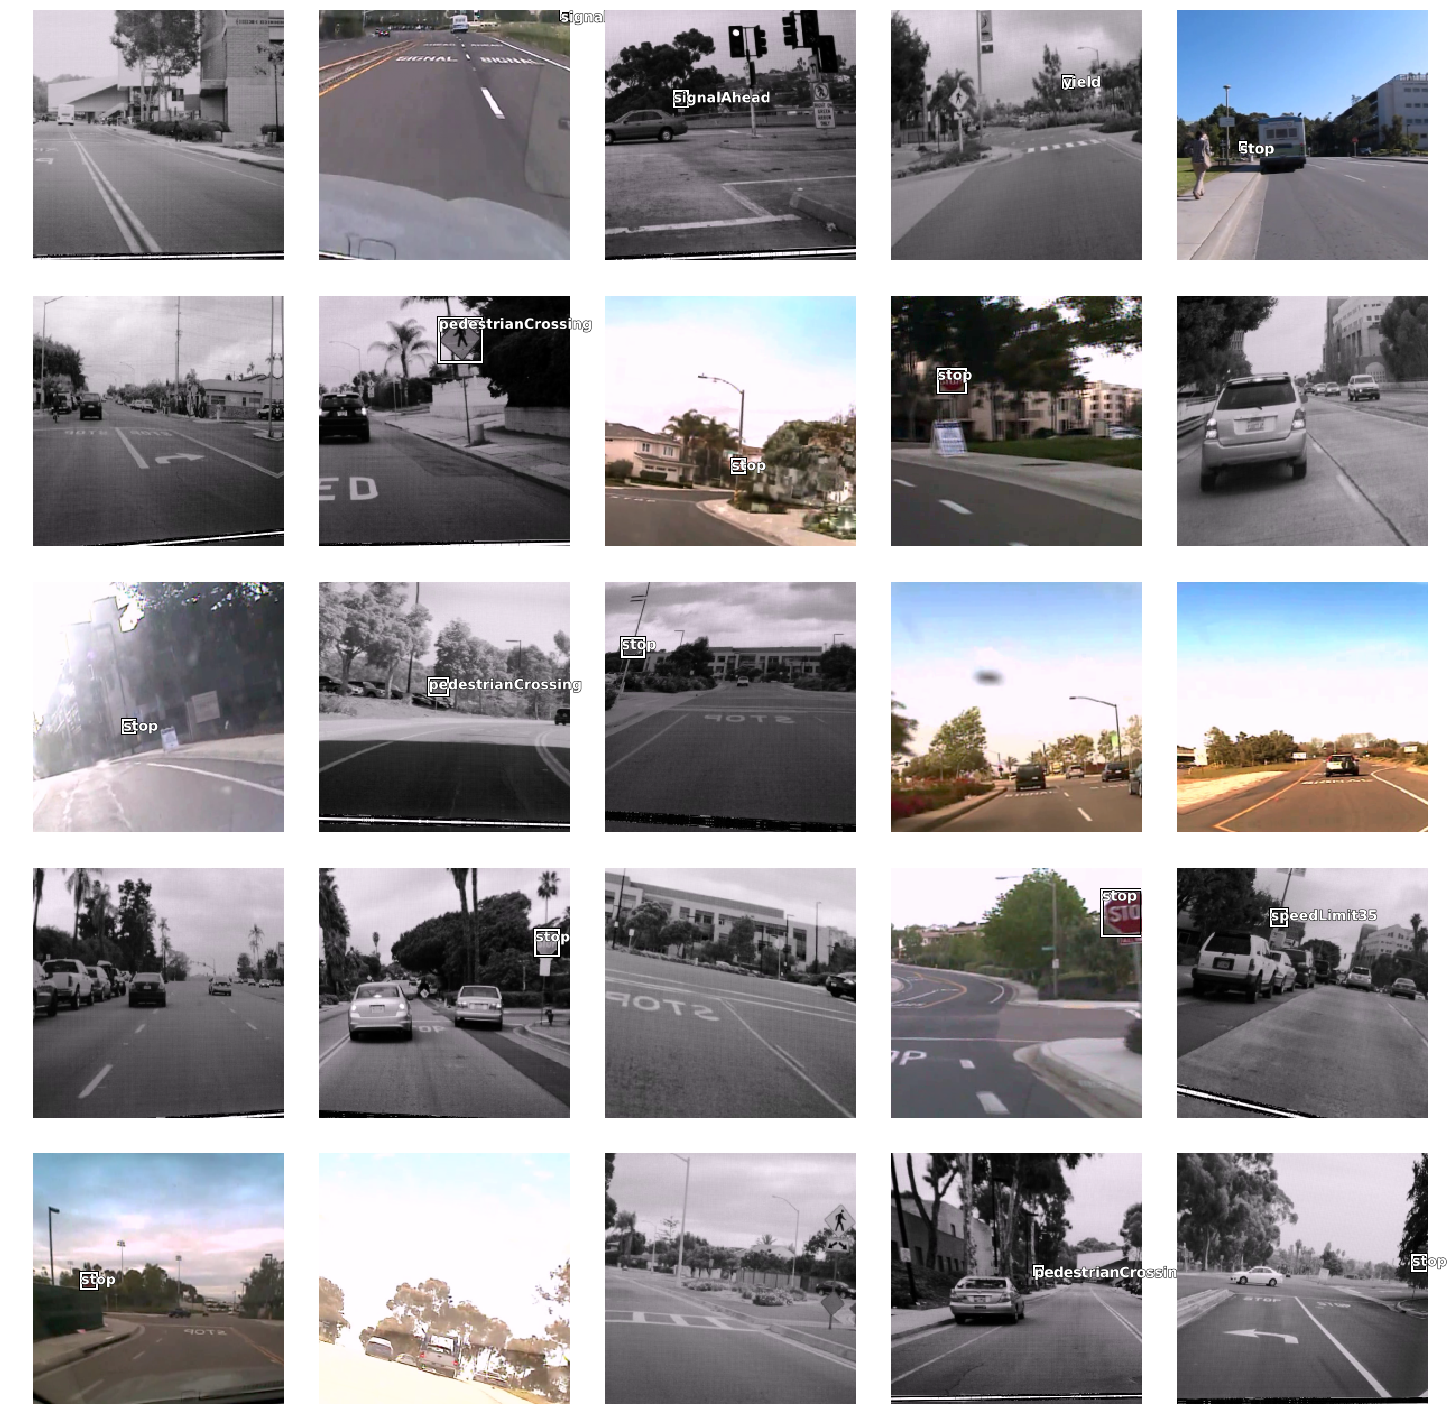

In [10]:
%%time
data.show_batch()

## Training

In [41]:
ssd = SingleShotDetector(data)

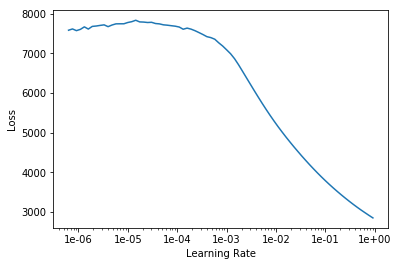

In [42]:
ssd.lr_find()

In [43]:
ssd.fit(20, lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,time
0,411.742035,42.046997,00:30
1,147.671219,34.605370,00:29
2,76.785828,33.410263,00:30
3,51.196461,30.969385,00:29
4,40.419888,30.624407,00:29
5,34.883976,31.064827,00:29
6,33.537186,29.339447,00:29
7,31.292177,28.356972,00:31
8,30.566999,27.894854,00:30
9,29.504341,26.734140,00:29


In [45]:
ssd.save('ssd-signs')

In [46]:
ssd.load('ssd-signs')

## Results

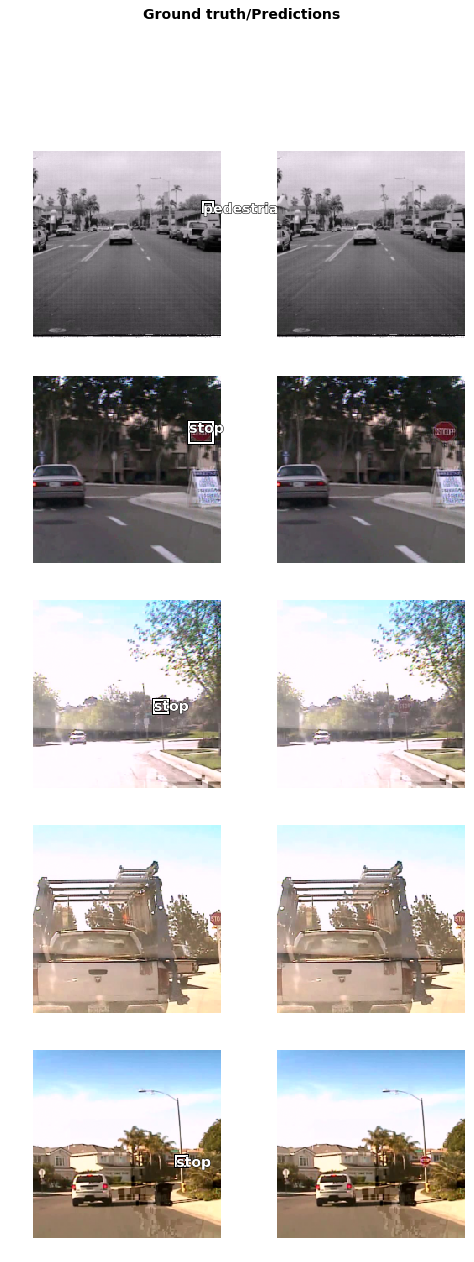

In [52]:
ssd.show_results(rows=5, thresh=0.5)